# EEG Data Analysis Pipeline
This notebook demonstrates the workflow for loading, preprocessing, decomposing, and visualizing EEG data from an antidepressant study using Dynamic Mode Decomposition (DMD).

In [6]:
# Import required libraries
import pyedflib
import numpy as np
import pandas as pd
import mne
from pydmd import DMD
from scipy.signal import detrend, butter, filtfilt
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

## Set Data Path
Specify the path to the EEG dataset.

In [7]:
data_path = '../datasets/antidepressant-study/'

## Load EEG Data from EDF File
Define a function to load EEG data from an EDF file and return it as a NumPy array.

In [8]:
def edf_to_arr(edf_path):
    f = pyedflib.EdfReader(edf_path)
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
    return sigbufs

## Preprocessing EEG Data
Detrend, bandpass filter, and (optionally) standardize the EEG data.

In [9]:
def preprocessing(eeg_data, lowcut=4, highcut=45, samplingrate=250, order=4):
    eeg_detrended = detrend(eeg_data, axis=-1, type='linear')
    b, a = butter(order, [lowcut / (0.5 * samplingrate), highcut / (0.5 * samplingrate)], btype='band')
    eeg_bandfiltered = filtfilt(b, a, eeg_detrended, axis=-1)
    eeg_normalized = StandardScaler().fit_transform(eeg_bandfiltered.T).T
    return eeg_normalized

## Load and Preprocess Example EEG File
Load a sample EEG file and preprocess the first channel for demonstration.

In [11]:
test_arr = edf_to_arr(data_path + 'DD01S1EC-edf.edf')
test_arr_clean = preprocessing(test_arr)


## Visualize Raw and Preprocessed EEG Signal
Plot the original and preprocessed EEG signal for comparison.

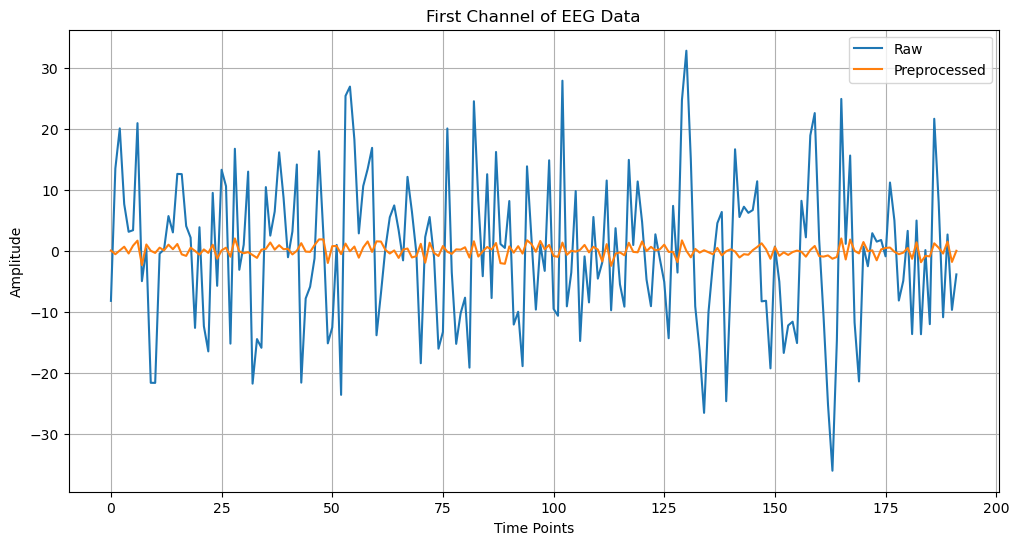

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(test_arr[0][::500], label='Raw')
plt.plot(test_arr_clean[0][::500], label='Preprocessed')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')
plt.title('First Channel of EEG Data')
plt.grid(True)
plt.legend()
plt.show()

## Dynamic Mode Decomposition (DMD)
Apply DMD to the EEG data to extract spatial and temporal modes.

In [15]:
dmd = DMD(svd_rank=10)
dmd.fit(test_arr_clean)
eigenvalues = dmd.eigs
dmd_modes = dmd.modes
dmd_amplitudes = dmd.amplitudes
dmd_dynamics = dmd.dynamics

## Visualize DMD Spectrum
Plot the frequency spectrum of the DMD modes.

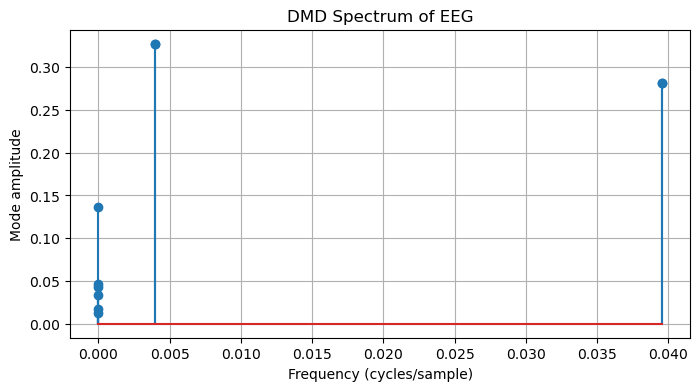

In [16]:
frequencies = np.abs(np.angle(eigenvalues)) / (2 * np.pi)
plt.figure(figsize=(8, 4))
plt.stem(frequencies, np.abs(dmd_amplitudes))
plt.xlabel("Frequency (cycles/sample)")
plt.ylabel("Mode amplitude")
plt.title("DMD Spectrum of EEG")
plt.grid(True)
plt.show()

## DMD Feature Extraction and Heatmap
Extract DMD features (damping ratios, frequencies, real/imaginary parts of modes) and visualize as a heatmap.

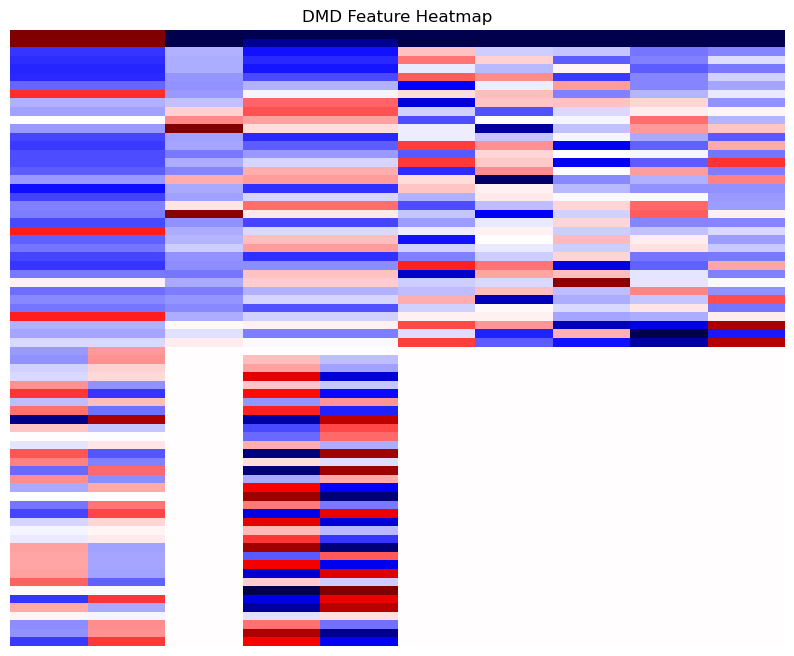

In [17]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

Phi_phys_unique_real = np.real(dmd_modes)
Phi_phys_unique_imag = np.imag(dmd_modes)
damping_ratios = -np.real(eigenvalues) / np.sqrt(np.real(eigenvalues)**2 + np.imag(eigenvalues)**2)
frequencies = np.abs(np.angle(eigenvalues)) / (2 * np.pi)

Phi_phys_unique_norm_real = normalize(Phi_phys_unique_real)
Phi_phys_unique_norm_imag = normalize(Phi_phys_unique_imag)
zeta_map = normalize(damping_ratios)
fn_map = normalize(frequencies)

heatmap_data = np.vstack([
    zeta_map,
    fn_map,
    Phi_phys_unique_norm_real,
    Phi_phys_unique_norm_imag
])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='seismic', cbar=False, xticklabels=False, yticklabels=False)
plt.title('DMD Feature Heatmap')
plt.show()

## Batch Processing

The same process will be applied to all the files at once by running the file `../file_processing.py`. The average optimal `svd_rank` was calculated to be 10, and it was applied to all the heatmaps.